In [1]:
import gensim
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
import random
from glob import glob
from string import punctuation

import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from dateutil import parser
import numpy as np
from tqdm import tqdm

from nltk.tokenize import TreebankWordTokenizer

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /Users/anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print(f"Your gensim version is {gensim.__version__}. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.")
assert int(gensim.__version__[0])>=4

print(f"Your pyLDAvis version is {pyLDAvis.__version__}. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.")
assert int(pyLDAvis.__version__[0])>=3

Your gensim version is 4.1.2. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.
Your pyLDAvis version is 3.3.1. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.


/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA is probabilistic method. As a consequence, you may find slight variations in results for different runs of the model. To make sure our findings are reproducable, we have to set a seed. In addition, we have to use `distributed=False` to get reproducable findings. 

In [4]:
random.seed(2022)
np.random.seed(2022)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
## load data
PATH = '/Users/anne/repos/CCS-2/week04/resources/articles'

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
RANDOM_N = 2000

def read_data(listofoutlets, RANDOM_N):
    date = []
    title = []
    outlets = []
    texts = []
    for outlet in listofoutlets:
        
        for file in random.choices(glob(f'{PATH}/*/{outlet}/*'), k=RANDOM_N):
            date.append(file.split('--')[-2])
            title.append(file.split('--')[-1])
            with open(file) as f:
                texts.append(f.read())
                outlets.append(outlet)
    return date, title, texts, outlets

dates, title, texts, outlets = read_data(['Infowars'], RANDOM_N)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
len(texts)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2000

In [8]:
texts[0][:500]

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'The August recess cant come soon enough for Nancy Pelosi.\n\nThe House Minority Leader held her last press conference before the 5-week break, and she was seen again having brain freezes, marring words and seemed to think the meeting and press conference with President Trump and Vladimir Putin, held 9 days earlier in Helsinki, was today.\n\nPelosi told reporters on Thursday that Democrats are for lower progr prescription drug prices.\n\nMoments later, she got confused about what day it was.\n\nToday Mon'

In [9]:
texts_clean = [text.lower() for text in texts]
texts_clean=[" ".join(text.split()) for text in texts_clean]  #remove dubble spaces
texts_clean = ["".join([l for l in text if l not in punctuation]) for text in texts_clean] #remove punctuaction
texts_clean[0][:500]

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'the august recess cant come soon enough for nancy pelosi the house minority leader held her last press conference before the 5week break and she was seen again having brain freezes marring words and seemed to think the meeting and press conference with president trump and vladimir putin held 9 days earlier in helsinki was today pelosi told reporters on thursday that democrats are for lower progr prescription drug prices moments later she got confused about what day it was today monday not today '

## manually removing stopwords

In [10]:
mystopwords = set(stopwords.words('english')) # use default NLTK stopword list; alternatively:
# mystopwords = set(open('mystopwordfile.txt').readlines())  #read stopword list from a textfile with one stopword per line
texts_clean = [" ".join(word for word in text.split() if word not in mystopwords) for text in texts_clean]
texts_clean[0][:500]

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'august recess cant come soon enough nancy pelosi house minority leader held last press conference 5week break seen brain freezes marring words seemed think meeting press conference president trump vladimir putin held 9 days earlier helsinki today pelosi told reporters thursday democrats lower progr prescription drug prices moments later got confused day today monday today monday marks 53rd year said citing wrong day week forced correct marred trillion saying trallion suffering brain freeze state'

## Tokenize texts

In [11]:
tokenized_texts_clean = [TreebankWordTokenizer().tokenize(text) for text in texts_clean ] # tokenize texts; convert all strings to a list of tokens
tokenized_texts_clean[0][:500]

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['august',
 'recess',
 'cant',
 'come',
 'soon',
 'enough',
 'nancy',
 'pelosi',
 'house',
 'minority',
 'leader',
 'held',
 'last',
 'press',
 'conference',
 '5week',
 'break',
 'seen',
 'brain',
 'freezes',
 'marring',
 'words',
 'seemed',
 'think',
 'meeting',
 'press',
 'conference',
 'president',
 'trump',
 'vladimir',
 'putin',
 'held',
 '9',
 'days',
 'earlier',
 'helsinki',
 'today',
 'pelosi',
 'told',
 'reporters',
 'thursday',
 'democrats',
 'lower',
 'progr',
 'prescription',
 'drug',
 'prices',
 'moments',
 'later',
 'got',
 'confused',
 'day',
 'today',
 'monday',
 'today',
 'monday',
 'marks',
 '53rd',
 'year',
 'said',
 'citing',
 'wrong',
 'day',
 'week',
 'forced',
 'correct',
 'marred',
 'trillion',
 'saying',
 'trallion',
 'suffering',
 'brain',
 'freeze',
 'statement',
 'deficit',
 'claiming',
 'democrats',
 'would',
 'protect',
 'democracy',
 'russia',
 'inserted',
 'unknown',
 'word',
 'statement',
 'attacking',
 'trump',
 'john',
 'mccains',
 'condemnation',
 's

## prepare the corpus for topic modelling

In [12]:
raw_m1 = tokenized_texts_clean
id2word_m1 = corpora.Dictionary(raw_m1)   # assign a token_id to each word
ldacorpus_m1 = [id2word_m1.doc2bow(text) for text in raw_m1] 

lda_m1 = models.LdaModel(ldacorpus_m1, id2word=id2word_m1, num_topics=10)
lda_m1.print_topics()

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"said" + 0.009*"trump" + 0.007*"president" + 0.004*"fbi" + 0.004*"one" + 0.003*"people" + 0.003*"also" + 0.003*"us" + 0.003*"former" + 0.003*"would"'),
 (1,
  '0.013*"trump" + 0.008*"president" + 0.005*"said" + 0.004*"media" + 0.004*"would" + 0.004*"people" + 0.004*"us" + 0.003*"new" + 0.003*"one" + 0.003*"also"'),
 (2,
  '0.007*"said" + 0.007*"trump" + 0.005*"us" + 0.005*"president" + 0.005*"new" + 0.004*"one" + 0.004*"would" + 0.003*"people" + 0.003*"also" + 0.003*"white"'),
 (3,
  '0.017*"trump" + 0.006*"president" + 0.006*"said" + 0.004*"people" + 0.004*"cnn" + 0.004*"also" + 0.003*"us" + 0.003*"house" + 0.003*"donald" + 0.003*"one"'),
 (4,
  '0.012*"trump" + 0.009*"said" + 0.007*"president" + 0.004*"people" + 0.004*"media" + 0.004*"one" + 0.004*"would" + 0.003*"us" + 0.003*"fbi" + 0.003*"news"'),
 (5,
  '0.010*"trump" + 0.006*"president" + 0.006*"people" + 0.005*"said" + 0.004*"fbi" + 0.004*"house" + 0.004*"would" + 0.004*"us" + 0.004*"one" + 0.004*"democrats"'),
 (6

### Use TFidF instead of word counts

In [13]:
ldacorpus_m2 = ldacorpus_m1 # reuse corpus from Model 1 
id2word_m2 = id2word_m1 # and thus, also use id2word-mapping

tfidfcorpus_m2 = models.TfidfModel(ldacorpus_m2)

lda_m2 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2,num_topics=10)
lda_m2.print_topics(num_words=5)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.001*"trump" + 0.001*"president" + 0.001*"said" + 0.001*"fbi" + 0.001*"north"'),
 (1,
  '0.001*"gun" + 0.001*"people" + 0.001*"trump" + 0.001*"students" + 0.001*"one"'),
 (2,
  '0.001*"trump" + 0.001*"president" + 0.001*"infowars" + 0.001*"obama" + 0.001*"border"'),
 (3,
  '0.001*"trump" + 0.001*"said" + 0.001*"immigration" + 0.001*"president" + 0.001*"border"'),
 (4,
  '0.001*"trump" + 0.001*"border" + 0.001*"president" + 0.001*"democrats" + 0.001*"us"'),
 (5,
  '0.001*"trump" + 0.001*"president" + 0.001*"said" + 0.001*"cnn" + 0.001*"house"'),
 (6,
  '0.001*"trump" + 0.001*"president" + 0.001*"democrats" + 0.001*"said" + 0.001*"house"'),
 (7,
  '0.001*"trump" + 0.001*"clinton" + 0.001*"president" + 0.001*"said" + 0.001*"new"'),
 (8,
  '0.001*"trump" + 0.001*"fbi" + 0.001*"us" + 0.001*"people" + 0.001*"percent"'),
 (9,
  '0.001*"trump" + 0.001*"news" + 0.001*"president" + 0.001*"us" + 0.001*"said"')]

### Using N-grams as features

In [14]:
documents_bigrams = [["_".join(tup) for tup in nltk.ngrams(text.split(),2)] for text in texts_clean] # creates bigrams
documents_bigrams[0][:500] # inspect the results...

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['august_recess',
 'recess_cant',
 'cant_come',
 'come_soon',
 'soon_enough',
 'enough_nancy',
 'nancy_pelosi',
 'pelosi_house',
 'house_minority',
 'minority_leader',
 'leader_held',
 'held_last',
 'last_press',
 'press_conference',
 'conference_5week',
 '5week_break',
 'break_seen',
 'seen_brain',
 'brain_freezes',
 'freezes_marring',
 'marring_words',
 'words_seemed',
 'seemed_think',
 'think_meeting',
 'meeting_press',
 'press_conference',
 'conference_president',
 'president_trump',
 'trump_vladimir',
 'vladimir_putin',
 'putin_held',
 'held_9',
 '9_days',
 'days_earlier',
 'earlier_helsinki',
 'helsinki_today',
 'today_pelosi',
 'pelosi_told',
 'told_reporters',
 'reporters_thursday',
 'thursday_democrats',
 'democrats_lower',
 'lower_progr',
 'progr_prescription',
 'prescription_drug',
 'drug_prices',
 'prices_moments',
 'moments_later',
 'later_got',
 'got_confused',
 'confused_day',
 'day_today',
 'today_monday',
 'monday_today',
 'today_monday',
 'monday_marks',
 'marks_53rd'

In [15]:
# maybe we want both unigrams and bigrams in the feature set?
documents_uniandbigrams = []
for a,b in zip([text.split() for text in texts_clean],documents_bigrams):
    documents_uniandbigrams.append(a + b)

#and let's inspect the outcomes again.
documents_uniandbigrams[0]

len(documents_uniandbigrams[0]),len(documents_bigrams[0]),len(texts_clean[0].split())

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(317, 158, 159)

In [17]:
id2word_m3 = corpora.Dictionary(documents_uniandbigrams)
id2word_m3.filter_extremes(no_below=5, no_above=0.5)

ldacorpus_m3 = [id2word_m3.doc2bow(text) for text in documents_uniandbigrams]
tfidfcorpus_m3 = models.TfidfModel(ldacorpus_m3)

lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m3[ldacorpus_m3],id2word=id2word_m3,num_topics=10)
lda_m3.print_topics(num_words=5)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.001*"trump" + 0.001*"jones" + 0.001*"infowars" + 0.001*"media" + 0.001*"president"'),
 (1,
  '0.001*"trump" + 0.001*"cnn" + 0.001*"said" + 0.001*"school" + 0.001*"president"'),
 (2,
  '0.002*"trump" + 0.001*"border" + 0.001*"president" + 0.001*"mueller" + 0.001*"said"'),
 (3,
  '0.001*"trump" + 0.001*"democrats" + 0.001*"border" + 0.001*"people" + 0.001*"percent"'),
 (4,
  '0.001*"trump" + 0.001*"infowars" + 0.001*"jones" + 0.001*"news" + 0.001*"media"'),
 (5,
  '0.001*"trump" + 0.001*"president" + 0.001*"white" + 0.001*"state" + 0.001*"ballots"'),
 (6,
  '0.001*"trump" + 0.001*"said" + 0.001*"president" + 0.001*"state" + 0.001*"fbi"'),
 (7,
  '0.001*"trump" + 0.001*"president" + 0.001*"paul" + 0.001*"fbi" + 0.001*"people"'),
 (8,
  '0.001*"school" + 0.001*"trump" + 0.001*"shooting" + 0.001*"gun" + 0.001*"us"'),
 (9,
  '0.001*"trump" + 0.001*"people" + 0.001*"said" + 0.001*"border" + 0.001*"president"')]

# 2. Model evaluation

In [18]:
# NB: CoherenceModel is only available in newer versions of gensim.
# if it's not available, consider upgrading with `pip3 install gensim -upgrade`


#The greater the number, the better is coherence score


cm1 = models.CoherenceModel(model=lda_m1, corpus=ldacorpus_m1 , dictionary=id2word_m1, coherence='u_mass')  
ch1 = cm1.get_coherence()
cm2 = models.CoherenceModel(model=lda_m2, corpus=ldacorpus_m2, dictionary= id2word_m2, coherence='u_mass')  
ch2 = cm2.get_coherence()
#cm3 = models.CoherenceModel(model=lda_m3, corpus=ldacorpus_m3, coherence='u_mass')
cm3 = models.CoherenceModel(model=lda_m3, corpus=tfidfcorpus_m3[ldacorpus_m3], dictionary= id2word_m3, coherence='u_mass')
ch3 = cm3.get_coherence()

print(f"Coherence of naive model = {ch1}\nCoherence of tfidf model = {ch2}\nCoherence of bigram and unigram model = {ch3}")

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence of naive model = -1.4162735239857995
Coherence of tfidf model = -2.0736419886533346
Coherence of bigram and unigram model = -2.109625626171269


In [19]:
lda_m2_bad = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=1)
print(models.CoherenceModel(model=lda_m2_bad, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

#lda_m2_good = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=10,iterations=50, passes=5)
#print(models.CoherenceModel(model=lda_m4_good, corpus=tfidfcorpus_m4[ldacorpus_m4], coherence='u_mass').get_coherence())

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-1.8576228862756614


In [20]:
lda_m2_good = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=50, passes=5)
print(models.CoherenceModel(model=lda_m2_good, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-7.488195763365992


In [21]:
lda_m2_good.top_topics(tfidfcorpus_m2[ldacorpus_m2])

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[([(0.0022266381, 'trump'),
   (0.0015837423, 'border'),
   (0.0015796074, 'president'),
   (0.0015367396, 'said'),
   (0.0014375076, 'democrats'),
   (0.0014314693, 'infowars'),
   (0.0014172825, 'people'),
   (0.0013485372, 'fbi'),
   (0.0012923349, 'school'),
   (0.0012796009, 'would'),
   (0.0012694054, 'us'),
   (0.0012176993, 'media'),
   (0.0012011576, 'jones'),
   (0.0011866412, 'news'),
   (0.0011305045, 'cnn'),
   (0.0011186013, 'one'),
   (0.0011143702, 'percent'),
   (0.0010899374, 'new'),
   (0.0010672632, 'house'),
   (0.0010512858, 'also')],
  -1.7199322446196508),
 ([(0.0010451103, 'trump'),
   (0.00096649746, 'acosta'),
   (0.00096369104, 'cnn'),
   (0.0007798743, 'white'),
   (0.0007621504, 'cohen'),
   (0.0007128795, 'jones'),
   (0.0007025127, 'video'),
   (0.0006877879, 'press'),
   (0.0006785376, 'trumps'),
   (0.0006613906, 'us'),
   (0.00065618695, 'shooting'),
   (0.0006526568, 'fake'),
   (0.0006516533, 'president'),
   (0.0006405816, 'alex'),
   (0.0006391934

## Visualize

In [22]:
vis_data = gensimvis.prepare(lda_m2,ldacorpus_m2,id2word_m2)
pyLDAvis.display(vis_data)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## plot over time

In [ ]:
## convert back to df

In [23]:
all_topics = lda_m2.get_document_topics(ldacorpus_m2, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df.head()

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
0,0.000631,0.000631,0.000631,0.335323,0.319663,0.000631,0.000631,0.340597,0.000631,0.000631
1,0.001438,0.001438,0.001438,0.427025,0.001438,0.001438,0.001438,0.001438,0.001438,0.561474
2,0.457334,0.000790,0.000790,0.000790,0.000790,0.000790,0.000790,0.000790,0.536344,0.000790
3,0.044702,0.412410,0.000484,0.038420,0.000484,0.422107,0.079942,0.000484,0.000484,0.000484
4,0.064362,0.000544,0.000544,0.479094,0.000544,0.000544,0.092490,0.360791,0.000544,0.000544


In [24]:
all_topics_df.rename(columns= { 0 : "topic_0", 1 : "topic_1", 2 : "topic_2", 3 : "topic_3",
4 : "topic_4", 5 : "topic_5", 6 : "topic_6", 7 : "topic_7", 8 : "topic_8", 9 : "topic_9" },inplace=True)
all_topics_df.head()

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000631,0.000631,0.000631,0.335323,0.319663,0.000631,0.000631,0.340597,0.000631,0.000631
1,0.001438,0.001438,0.001438,0.427025,0.001438,0.001438,0.001438,0.001438,0.001438,0.561474
2,0.457334,0.000790,0.000790,0.000790,0.000790,0.000790,0.000790,0.000790,0.536344,0.000790
3,0.044702,0.412410,0.000484,0.038420,0.000484,0.422107,0.079942,0.000484,0.000484,0.000484
4,0.064362,0.000544,0.000544,0.479094,0.000544,0.000544,0.092490,0.360791,0.000544,0.000544


In [25]:
### create a df with the dates and orginal texts

meta = pd.DataFrame(zip(dates, texts))
meta.rename(columns = {0: "date", 1 : "texts"}, inplace=True)

meta.head()

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,texts
0,2018-07-28,The August recess cant come soon enough for Na...
1,2018-04-18,The View host Meghan McCain took former FBI Di...
2,2018-05-17,"Scot Peterson, a former deputy with the Browar..."
3,2018-03-13,"Trump derangement syndrome persists at MSNBC, ..."
4,2018-05-12,AG Jefferson Beauregard Sessions might as well...


In [26]:
### merge with the topic scores per document

final = pd.concat([meta, all_topics_df], axis=1)
final['id'] = final.index
final.head(3)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,texts,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,id
0,2018-07-28,The August recess cant come soon enough for Na...,0.000631,0.000631,0.000631,0.335323,0.319663,0.000631,0.000631,0.340597,0.000631,0.000631,0
1,2018-04-18,The View host Meghan McCain took former FBI Di...,0.001438,0.001438,0.001438,0.427025,0.001438,0.001438,0.001438,0.001438,0.001438,0.561474,1
2,2018-05-17,"Scot Peterson, a former deputy with the Browar...",0.457334,0.000790,0.000790,0.000790,0.000790,0.000790,0.000790,0.000790,0.536344,0.000790,2


In [27]:
### reshape to long format

long = pd.melt(final, id_vars=['id', 'date', 'texts'], value_vars=[f"topic_{i}" for i in range(0,10)])
long.rename(columns={"variable" : "topic_nr", "value" : "topic_score"}, inplace=True)
long.head(3)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,date,texts,topic_nr,topic_score
0,0,2018-07-28,The August recess cant come soon enough for Na...,topic_0,0.000631
1,1,2018-04-18,The View host Meghan McCain took former FBI Di...,topic_0,0.001438
2,2,2018-05-17,"Scot Peterson, a former deputy with the Browar...",topic_0,0.457334


In [28]:
# get data in right shape for plotting
import seaborn as sns

long['date'] = long['date'].map(pd.to_datetime)
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).sum().reset_index() 
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).mean().reset_index() #you may also opt for 'mean'

long['month'] = pd.DatetimeIndex(long['date']).month

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='month', ylabel='topic_score'>

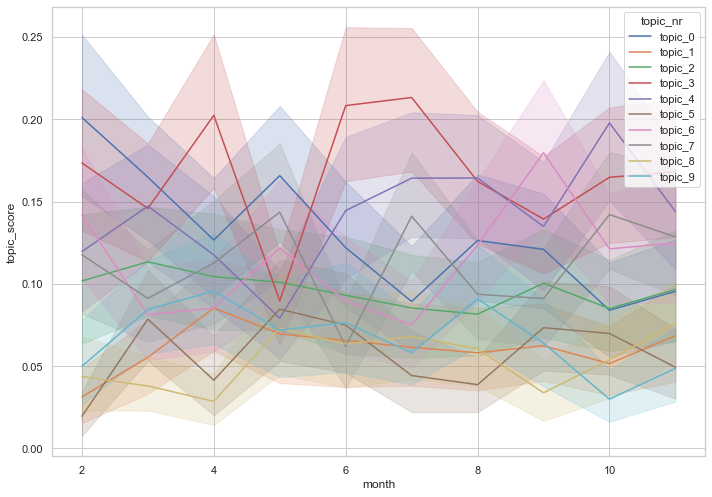

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

sns.lineplot(x="month", y="topic_score", hue="topic_nr", data=long)